In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from kneebow.rotor import Rotor
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import os
import re

## Funciones auxiliares

In [85]:
#We calculate or k-distance for determinate our eps value.
def calculate_kn_distance(X, neigh=2):
    neigh = NearestNeighbors(n_neighbors=neigh)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    return distances[:,1:].reshape(-1)

#We get the eps exact value using kneebow, this function allows
#us to find the elbow of a curve by rotating the curve and taking
#the minimum value.
def get_eps(X, neigh=2):
    eps_dist = np.sort(calculate_kn_distance(X, neigh=neigh))
    rotor = Rotor()
    curve_xy = np.concatenate([np.arange(eps_dist.shape[0]).reshape(-1, 1), eps_dist.reshape(-1, 1)],1)
    rotor.fit_rotate(curve_xy)
    rotor.plot_elbow()
    e_idx = rotor.get_elbow_index()
    return curve_xy[e_idx]

## carga de datos 

In [86]:
file_path="../data/interim/estadisticas_edificios.csv"

In [87]:
data = pd.read_csv(file_path)
data.head()

,type_building,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Electricity:Facility [kW](Hourly)_max_value,Electricity:Facility [kW](Hourly)_min_value,Electricity:Facility [kW](Hourly)_25_percentile,Electricity:Facility [kW](Hourly)_50_percentile,Electricity:Facility [kW](Hourly)_75_percentile,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
0,RefBldgFullServiceRestaurantNew2004,36.968830,13.139998,71.651343,14.590618,33.836563,38.877634,43.668457,3.331869,1.490142,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
1,RefBldgFullServiceRestaurantNew2004,37.357872,13.459672,73.124359,14.610946,34.289907,39.231781,44.710691,3.327967,1.488397,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
2,RefBldgFullServiceRestaurantNew2004,37.896555,13.945362,72.745300,14.594486,34.285619,39.321435,45.983973,3.327124,1.488020,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
3,RefBldgFullServiceRestaurantNew2004,35.892184,12.083141,71.557828,14.600000,33.768150,38.689354,42.586655,3.303988,1.477673,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
4,RefBldgFullServiceRestaurantNew2004,35.976038,12.127984,70.203381,14.593106,33.934022,38.713755,42.615663,3.323298,1.486309,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147


In [88]:
data.columns

Index(['type_building', 'Electricity:Facility [kW](Hourly)_mean',
       'Electricity:Facility [kW](Hourly)_std_dev',
       'Electricity:Facility [kW](Hourly)_max_value',
       'Electricity:Facility [kW](Hourly)_min_value',
       'Electricity:Facility [kW](Hourly)_25_percentile',
       'Electricity:Facility [kW](Hourly)_50_percentile',
       'Electricity:Facility [kW](Hourly)_75_percentile',
       'Fans:Electricity [kW](Hourly)_mean',
       'Fans:Electricity [kW](Hourly)_std_dev',
       'Fans:Electricity [kW](Hourly)_max_value',
       'Fans:Electricity [kW](Hourly)_min_value',
       'Fans:Electricity [kW](Hourly)_25_percentile',
       'Fans:Electricity [kW](Hourly)_50_percentile',
       'Fans:Electricity [kW](Hourly)_75_percentile',
       'Cooling:Electricity [kW](Hourly)_mean',
       'Cooling:Electricity [kW](Hourly)_std_dev',
       'Cooling:Electricity [kW](Hourly)_max_value',
       'Cooling:Electricity [kW](Hourly)_min_value',
       'Cooling:Electricity [kW](Hourly)

In [89]:
# Obtener un resumen estadístico y mostrar la información general del conjunto de datos
summary = data.describe()
summary

,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Electricity:Facility [kW](Hourly)_max_value,Electricity:Facility [kW](Hourly)_min_value,Electricity:Facility [kW](Hourly)_25_percentile,Electricity:Facility [kW](Hourly)_50_percentile,Electricity:Facility [kW](Hourly)_75_percentile,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_max_value,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,205.896959,94.554094,443.477615,70.457995,127.069353,180.856123,277.715774,17.075134,7.016523,45.769114,...,13.192541,21.508703,84.586268,53.206147,24.728418,93.059567,26.638005,33.139539,44.721192,77.250456
std,294.490158,128.967601,549.446174,114.916877,220.106359,274.716614,385.373052,24.649374,9.107792,69.280486,...,14.829699,24.725756,117.099512,73.554009,31.327799,119.627218,41.686298,47.366172,61.317985,109.151424
min,7.474270,4.002892,19.802128,1.925019,4.778024,6.033994,11.556660,1.217192,0.711591,2.184205,...,0.275003,0.550005,3.711679,2.781765,1.278151,4.950048,1.011600,1.011600,1.011600,4.400043
25%,32.447086,17.795171,89.810725,8.699267,17.785496,27.533792,48.293093,3.041448,1.416750,7.472911,...,3.105893,5.451126,20.528760,11.311712,4.654335,16.250509,4.198793,7.411378,11.303727,16.250509
50%,78.139872,40.073529,224.347158,25.164031,44.778556,62.731332,110.190792,5.733951,4.100985,11.780199,...,4.801828,11.914006,37.735226,25.334649,13.133033,49.700376,8.760066,15.207416,22.338642,38.770934
75%,218.748632,81.871898,416.974453,78.435727,118.747199,197.050593,283.287781,21.543638,6.633711,37.988283,...,18.128048,23.766720,67.296722,58.264945,27.107491,113.141618,23.552351,33.079399,44.437106,78.163553
max,1120.479725,478.877942,1886.608295,508.413289,952.791133,1066.621718,1383.350524,102.154344,37.823520,304.000110,...,46.093034,100.150657,448.566544,265.854193,116.539481,448.566544,149.522181,174.442545,199.362908,398.725817


In [90]:
info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 43 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   type_building                                             80 non-null     object 
 1   Electricity:Facility [kW](Hourly)_mean                    80 non-null     float64
 2   Electricity:Facility [kW](Hourly)_std_dev                 80 non-null     float64
 3   Electricity:Facility [kW](Hourly)_max_value               80 non-null     float64
 4   Electricity:Facility [kW](Hourly)_min_value               80 non-null     float64
 5   Electricity:Facility [kW](Hourly)_25_percentile           80 non-null     float64
 6   Electricity:Facility [kW](Hourly)_50_percentile           80 non-null     float64
 7   Electricity:Facility [kW](Hourly)_75_percentile           80 non-null     float64
 8   Fans:Electricity [kW](

In [91]:
# Identificar valores faltantes
missing_values = data.isnull().sum()
missing_values

type_building                                               0
Electricity:Facility [kW](Hourly)_mean                      0
Electricity:Facility [kW](Hourly)_std_dev                   0
Electricity:Facility [kW](Hourly)_max_value                 0
Electricity:Facility [kW](Hourly)_min_value                 0
Electricity:Facility [kW](Hourly)_25_percentile             0
Electricity:Facility [kW](Hourly)_50_percentile             0
Electricity:Facility [kW](Hourly)_75_percentile             0
Fans:Electricity [kW](Hourly)_mean                          0
Fans:Electricity [kW](Hourly)_std_dev                       0
Fans:Electricity [kW](Hourly)_max_value                     0
Fans:Electricity [kW](Hourly)_min_value                     0
Fans:Electricity [kW](Hourly)_25_percentile                 0
Fans:Electricity [kW](Hourly)_50_percentile                 0
Fans:Electricity [kW](Hourly)_75_percentile                 0
Cooling:Electricity [kW](Hourly)_mean                       0
Cooling:

In [92]:
# Seleccionar todas las columnas numéricas para la estandarización
numeric_columns = data.select_dtypes(include=['float64']).columns

# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_columns])

# Convertir de nuevo a un DataFrame para mantener la consistencia
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)
# Añadir la columna 'type_building' de nuevo
data_scaled_df['type_building'] = data['type_building']

# Mostrar los primeros registros del DataFrame estandarizado
data_scaled_df.head()


,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Electricity:Facility [kW](Hourly)_max_value,Electricity:Facility [kW](Hourly)_min_value,Electricity:Facility [kW](Hourly)_25_percentile,Electricity:Facility [kW](Hourly)_50_percentile,Electricity:Facility [kW](Hourly)_75_percentile,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_max_value,...,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile,type_building
0,-0.577248,-0.635258,-0.680999,-0.489222,-0.426253,-0.520079,-0.611158,-0.561068,-0.610603,-0.606728,...,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065,RefBldgFullServiceRestaurantNew2004
1,-0.575919,-0.632764,-0.678301,-0.489044,-0.424180,-0.518781,-0.608437,-0.561227,-0.610796,-0.606796,...,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065,RefBldgFullServiceRestaurantNew2004
2,-0.574078,-0.628974,-0.678995,-0.489188,-0.424200,-0.518453,-0.605112,-0.561262,-0.610838,-0.606811,...,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065,RefBldgFullServiceRestaurantNew2004
3,-0.580927,-0.643505,-0.681170,-0.489140,-0.426566,-0.520768,-0.613983,-0.562206,-0.611981,-0.607214,...,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065,RefBldgFullServiceRestaurantNew2004
4,-0.580641,-0.643155,-0.683651,-0.489200,-0.425808,-0.520679,-0.613908,-0.561418,-0.611027,-0.606877,...,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065,RefBldgFullServiceRestaurantNew2004


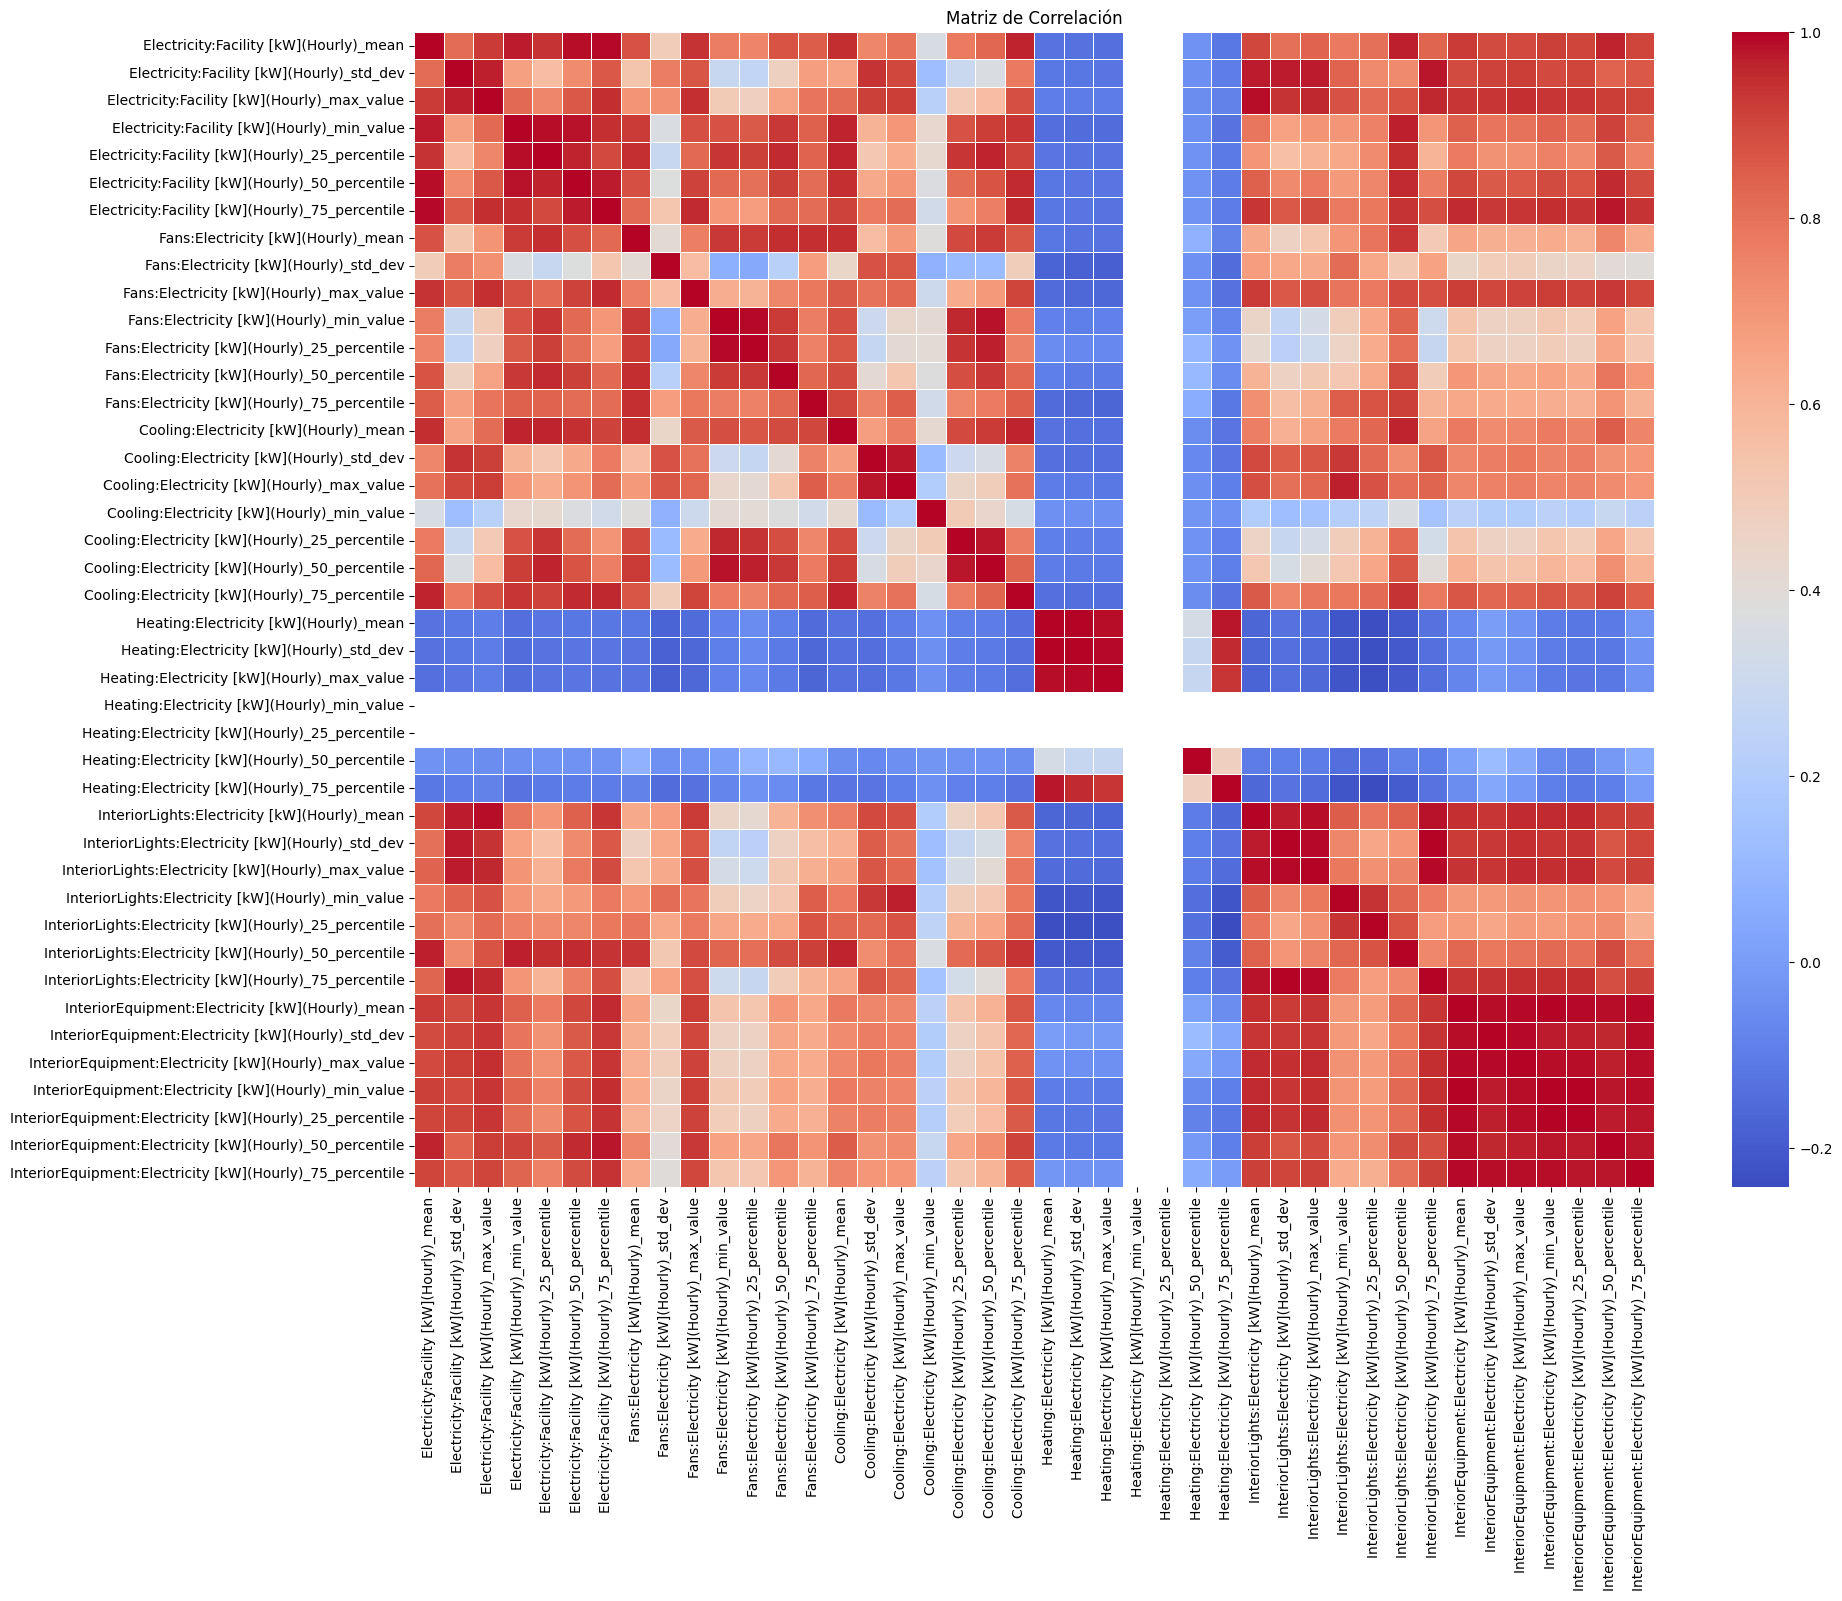

In [93]:
# Calcular la matriz de correlación
correlation_matrix = data_scaled_df.iloc[:,:-1].corr()

# Mostrar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [94]:
# Identificar características altamente correlacionadas (umbral > 0.9)
threshold = 0.9
high_corr_var = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_var.add(correlation_matrix.columns[i])

high_corr_var

{'Cooling:Electricity [kW](Hourly)_25_percentile',
 'Cooling:Electricity [kW](Hourly)_50_percentile',
 'Cooling:Electricity [kW](Hourly)_75_percentile',
 'Cooling:Electricity [kW](Hourly)_max_value',
 'Cooling:Electricity [kW](Hourly)_mean',
 'Cooling:Electricity [kW](Hourly)_std_dev',
 'Electricity:Facility [kW](Hourly)_25_percentile',
 'Electricity:Facility [kW](Hourly)_50_percentile',
 'Electricity:Facility [kW](Hourly)_75_percentile',
 'Electricity:Facility [kW](Hourly)_max_value',
 'Electricity:Facility [kW](Hourly)_min_value',
 'Fans:Electricity [kW](Hourly)_25_percentile',
 'Fans:Electricity [kW](Hourly)_50_percentile',
 'Fans:Electricity [kW](Hourly)_75_percentile',
 'Fans:Electricity [kW](Hourly)_max_value',
 'Fans:Electricity [kW](Hourly)_mean',
 'Fans:Electricity [kW](Hourly)_min_value',
 'Heating:Electricity [kW](Hourly)_75_percentile',
 'Heating:Electricity [kW](Hourly)_max_value',
 'Heating:Electricity [kW](Hourly)_std_dev',
 'InteriorEquipment:Electricity [kW](Hourly)_25

In [95]:
# Eliminar las características altamente correlacionadas
data_reduced = data_scaled_df.drop(columns=high_corr_var)

# Mostrar las primeras filas del nuevo DataFrame
data_reduced.head()

,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_std_dev,Cooling:Electricity [kW](Hourly)_min_value,Heating:Electricity [kW](Hourly)_mean,Heating:Electricity [kW](Hourly)_min_value,Heating:Electricity [kW](Hourly)_25_percentile,Heating:Electricity [kW](Hourly)_50_percentile,type_building
0,-0.577248,-0.635258,-0.610603,-0.113431,-0.378736,0.0,0.0,-0.225323,RefBldgFullServiceRestaurantNew2004
1,-0.575919,-0.632764,-0.610796,-0.113431,-0.378736,0.0,0.0,-0.225323,RefBldgFullServiceRestaurantNew2004
2,-0.574078,-0.628974,-0.610838,-0.113431,-0.378736,0.0,0.0,-0.225323,RefBldgFullServiceRestaurantNew2004
3,-0.580927,-0.643505,-0.611981,-0.113431,-0.378736,0.0,0.0,-0.225323,RefBldgFullServiceRestaurantNew2004
4,-0.580641,-0.643155,-0.611027,-0.113431,-0.378736,0.0,0.0,-0.225323,RefBldgFullServiceRestaurantNew2004


In [96]:
# Separar las características numéricas
features = data_reduced.drop(columns=['type_building'])

In [97]:
features.head()

,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_std_dev,Cooling:Electricity [kW](Hourly)_min_value,Heating:Electricity [kW](Hourly)_mean,Heating:Electricity [kW](Hourly)_min_value,Heating:Electricity [kW](Hourly)_25_percentile,Heating:Electricity [kW](Hourly)_50_percentile
0,-0.577248,-0.635258,-0.610603,-0.113431,-0.378736,0.0,0.0,-0.225323
1,-0.575919,-0.632764,-0.610796,-0.113431,-0.378736,0.0,0.0,-0.225323
2,-0.574078,-0.628974,-0.610838,-0.113431,-0.378736,0.0,0.0,-0.225323
3,-0.580927,-0.643505,-0.611981,-0.113431,-0.378736,0.0,0.0,-0.225323
4,-0.580641,-0.643155,-0.611027,-0.113431,-0.378736,0.0,0.0,-0.225323


## PCA

[2.54656107 1.31831313 1.02174822 0.66251095 0.43951742 0.08729858
 0.         0.        ]


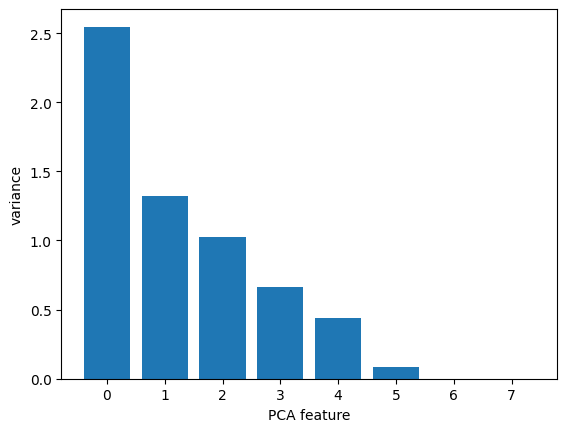

In [98]:
# Create a PCA instance: pca
pca = PCA()
# Fit the pipeline to 'samples'
pca.fit(features)
print(pca.explained_variance_)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

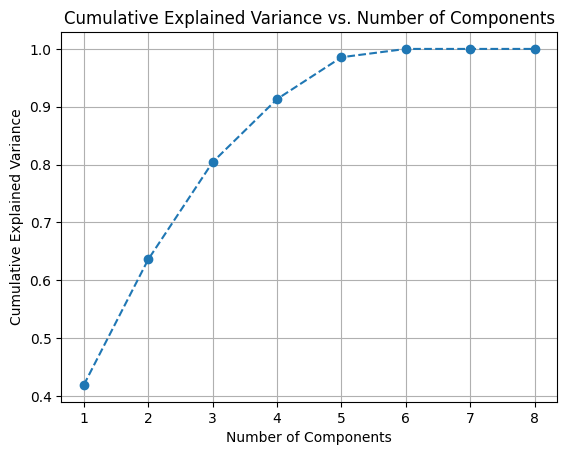

In [99]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [113]:
# Reducir la dimensionalidad utilizando PCA para seleccionar características no correlacionadas
# Separar las características numéricas
features = data_reduced.drop(columns=['type_building'])
pca = PCA(n_components=4)  # Seleccionamos un número razonable de componentes principales
principal_components = pca.fit_transform(features)

# Convertir a DataFrame para mantener la consistencia
principal_df =pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# # Añadir de nuevo la columna 'type_building'
# principal_df['type_building'] = data_reduced['type_building']

In [114]:
principal_df.head()

,PC1,PC2,PC3,PC4
0,-0.968858,-0.596223,0.144064,-0.181316
1,-0.966817,-0.595789,0.143797,-0.180974
2,-0.963688,-0.595137,0.143282,-0.180477
3,-0.976218,-0.597672,0.145726,-0.182308
4,-0.975393,-0.597554,0.145373,-0.182300


In [115]:
# Paso 1: Examinar las Componentes Principales (PCA)
pca_loadings = pd.DataFrame(pca.components_.T, index=features.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_loadings

,PC1,PC2,PC3,PC4
Electricity:Facility [kW](Hourly)_mean,5.364149e-01,0.111895,0.144092,6.178036e-02
Electricity:Facility [kW](Hourly)_std_dev,5.705875e-01,0.118045,-0.209649,1.006266e-01
Fans:Electricity [kW](Hourly)_std_dev,4.944880e-01,0.046871,-0.336393,-4.732353e-02
Cooling:Electricity [kW](Hourly)_min_value,2.123759e-01,0.051926,0.902482,-6.573026e-02
Heating:Electricity [kW](Hourly)_mean,-1.623217e-01,0.675298,0.022730,7.099111e-01
Heating:Electricity [kW](Hourly)_min_value,1.084202e-19,0.000000,-0.000000,-1.249001e-16
Heating:Electricity [kW](Hourly)_25_percentile,0.000000e+00,0.000000,-0.000000,0.000000e+00
Heating:Electricity [kW](Hourly)_50_percentile,-8.173704e-02,0.715514,-0.055160,-6.892138e-01
Cluster_KMeans,2.530569e-01,0.025756,0.063969,2.254005e-02


Las cargas de las componentes principales (PCA) indican qué variables originales tienen mayor influencia en cada componente. Aquí están algunas observaciones clave:

* PC1 está fuertemente influenciada por Electricity:Facility [kW](Hourly)_mean, Electricity:Facility [kW](Hourly)_std_dev y Fans:Electricity [kW](Hourly)_std_dev.
  
* PC2 está fuertemente influenciada por Heating:Electricity [kW](Hourly)_mean y Heating:Electricity [kW](Hourly)_50_percentile.
  
* PC3 está fuertemente influenciada por Cooling:Electricity [kW](Hourly)_min_value.

* PC4 está influenciada por Heating:Electricity [kW](Hourly)_mean y Heating:Electricity [kW](Hourly)_50_percentile.

## CLUSTERING 

### KMEANS

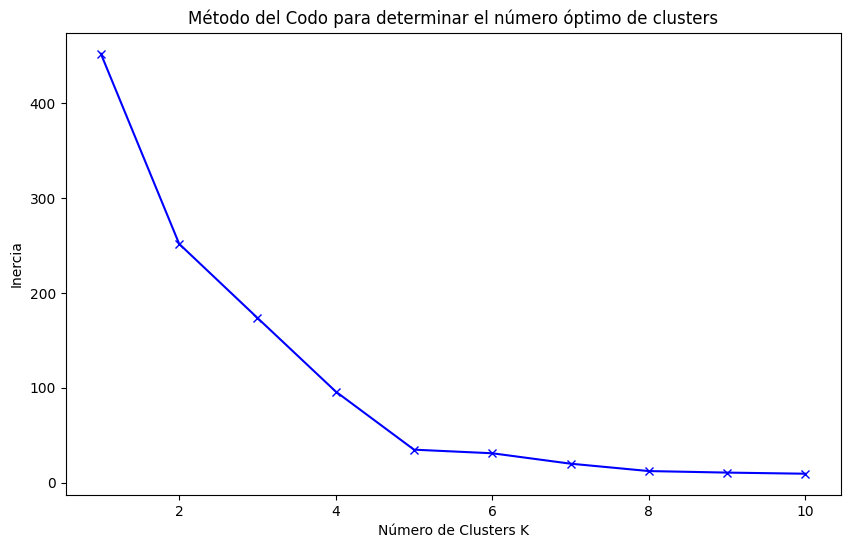

In [116]:
# Método del Codo para K-means
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_df.iloc[:, :4])
    inertia.append(kmeans.inertia_)

# Gráfico del Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Número de Clusters K')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

In [117]:
# Calcular las diferencias entre inercias
inertia_differences = [j - i for i, j in zip(inertia[:-1], inertia[1:])]
# Imprimir las diferencias entre inercias
for i, diff in enumerate(inertia_differences, start=2):
    print(f"Diferencia de inercia entre {i-1} y {i} clusters: {diff}")

Diferencia de inercia entre 1 y 2 clusters: -200.67228533852187
Diferencia de inercia entre 2 y 3 clusters: -78.1368473197912
Diferencia de inercia entre 3 y 4 clusters: -77.7073509807046
Diferencia de inercia entre 4 y 5 clusters: -61.353303421602746
Diferencia de inercia entre 5 y 6 clusters: -3.803107928578722
Diferencia de inercia entre 6 y 7 clusters: -10.991896011948938
Diferencia de inercia entre 7 y 8 clusters: -7.786675988902868
Diferencia de inercia entre 8 y 9 clusters: -1.6189115022470713
Diferencia de inercia entre 9 y 10 clusters: -1.1868161314818426


basandonos en la grafica de los cambios de inercia  utilizamos el metodo del codo para determinar el numero optimo de clusters a agrupar estan entre 2 a 3

In [155]:
# Aplicar K-means con un número de clusters razonable, por ejemplo, 3
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_kmeans = kmeans.fit_predict(principal_df.iloc[:, :4])

# Agregar los clusters al DataFrame para análisis posterior
principal_df['Cluster_KMeans'] = clusters_kmeans
data_reduced['Cluster_KMeans'] = clusters_kmeans
# Mostrar los primeros registros con los clusters asignados
principal_df.head()

,PC1,PC2,PC3,PC4,Cluster_KMeans,Cluster_DBSCAN,Cluster_Hierarchical
0,-0.968858,-0.596223,0.144064,-0.181316,0,0,0
1,-0.966817,-0.595789,0.143797,-0.180974,0,0,0
2,-0.963688,-0.595137,0.143282,-0.180477,0,0,0
3,-0.976218,-0.597672,0.145726,-0.182308,0,0,0
4,-0.975393,-0.597554,0.145373,-0.182300,0,0,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [156]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_kmeans = silhouette_score(principal_df.iloc[:, :4], clusters_kmeans)
silhouette_kmeans

0.6837201697838806

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [157]:
# Calcular el índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(principal_df.iloc[:, :4], clusters_kmeans)
davies_bouldin

0.6020345318930824

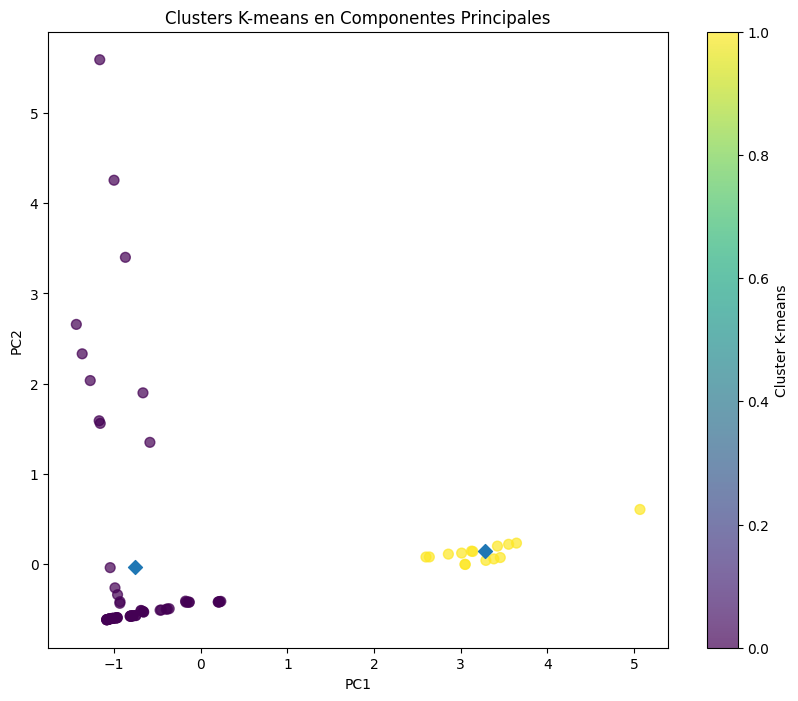

In [158]:
# Visualización de los clusters obtenidos por K-means
plt.figure(figsize=(10, 8))
plt.scatter(principal_df["PC1"], principal_df['PC2'], c=principal_df['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters K-means en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster K-means')
# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
"""
scatter plot of centroids_x and centroids_y, using 'D' (a diamond) as a marker by specifying the marker parameter. Set the size of the markers to be 50 using s=50.
"""
plt.scatter(centroids_x,centroids_y,marker="D",s=50)
plt.show()

In [122]:
principal_df.head()

,PC1,PC2,PC3,PC4,Cluster_KMeans
0,-0.968858,-0.596223,0.144064,-0.181316,0
1,-0.966817,-0.595789,0.143797,-0.180974,0
2,-0.963688,-0.595137,0.143282,-0.180477,0
3,-0.976218,-0.597672,0.145726,-0.182308,0
4,-0.975393,-0.597554,0.145373,-0.182300,0


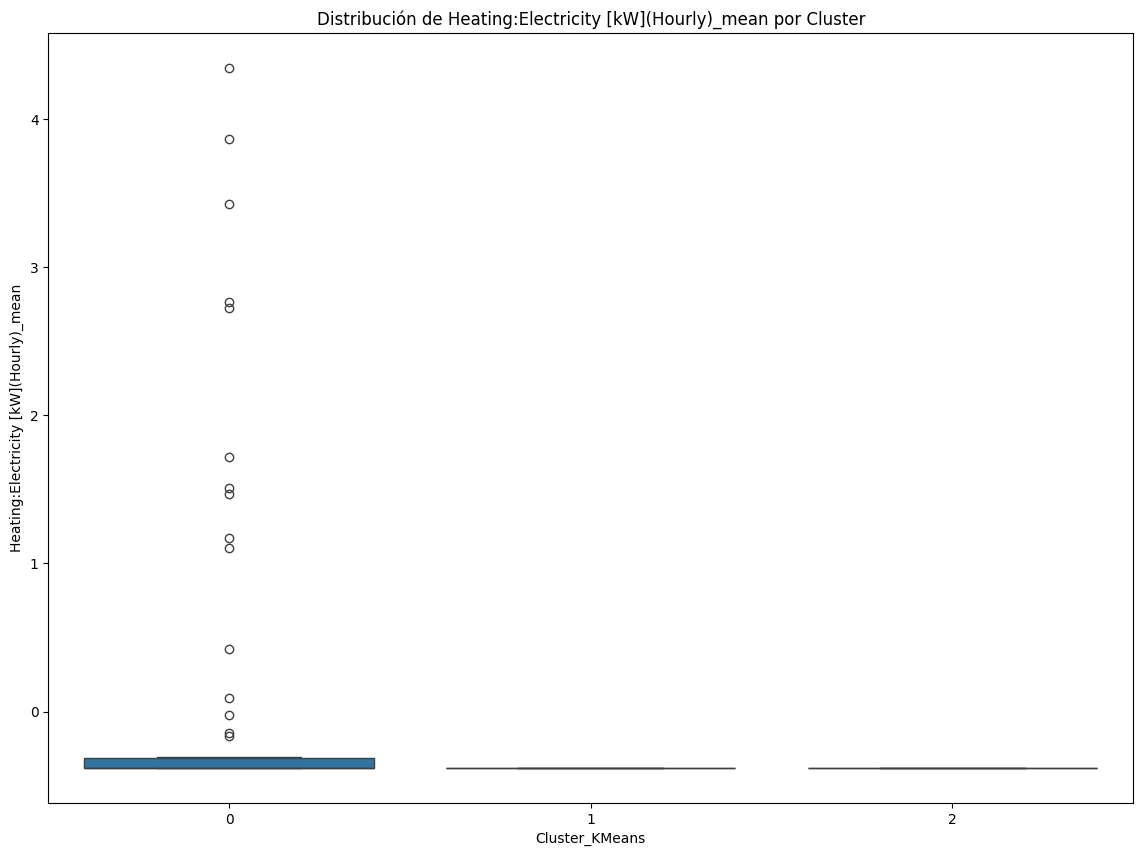

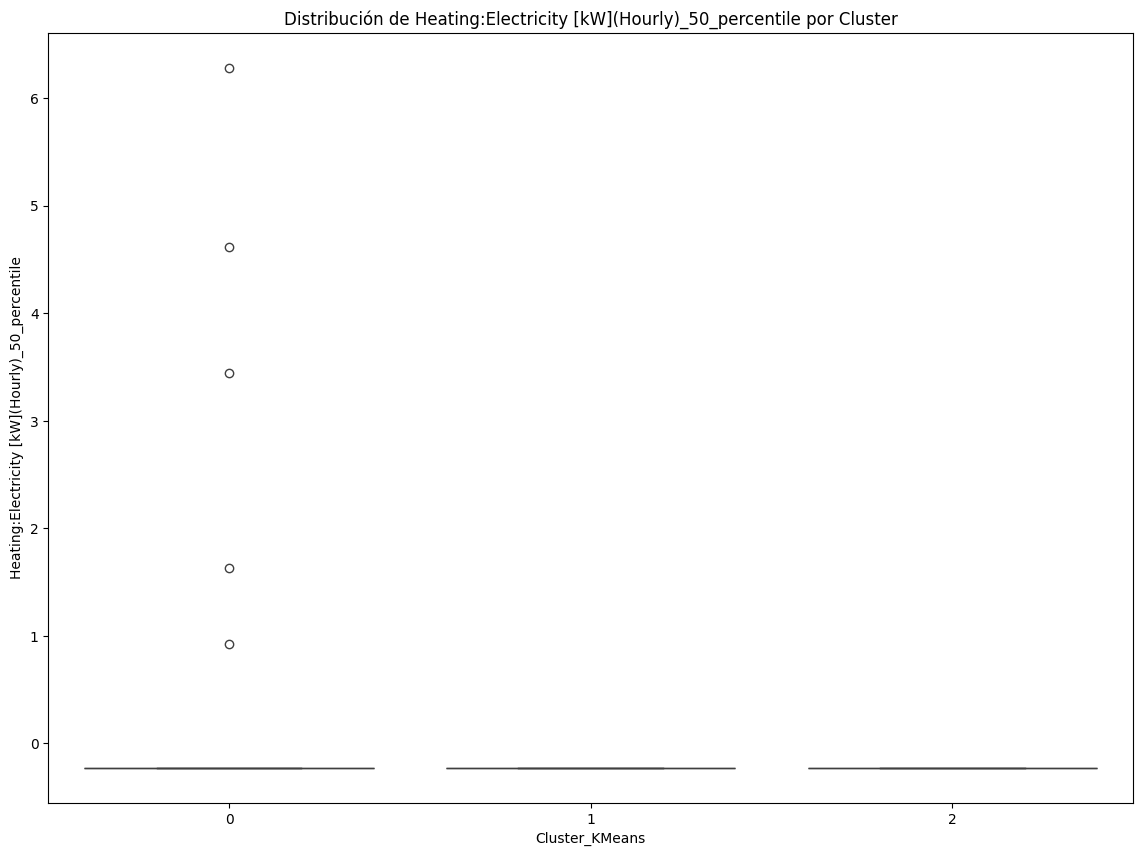

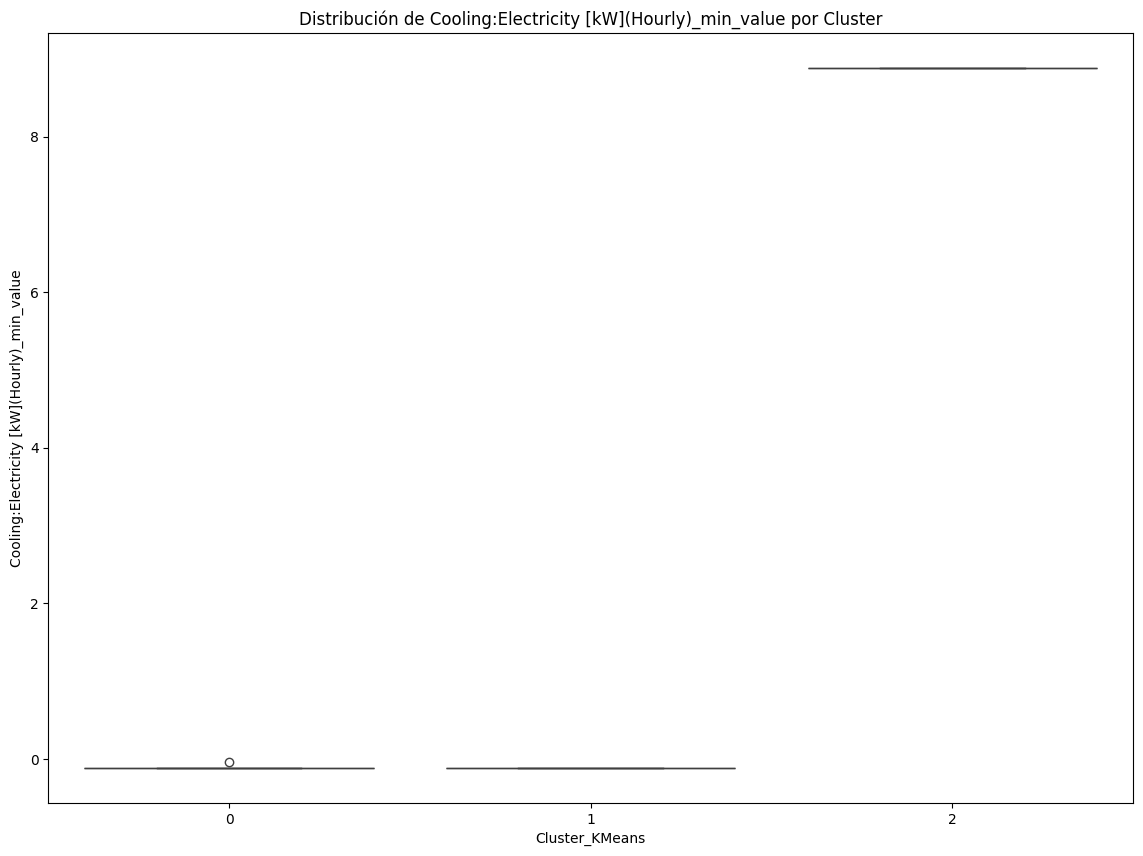

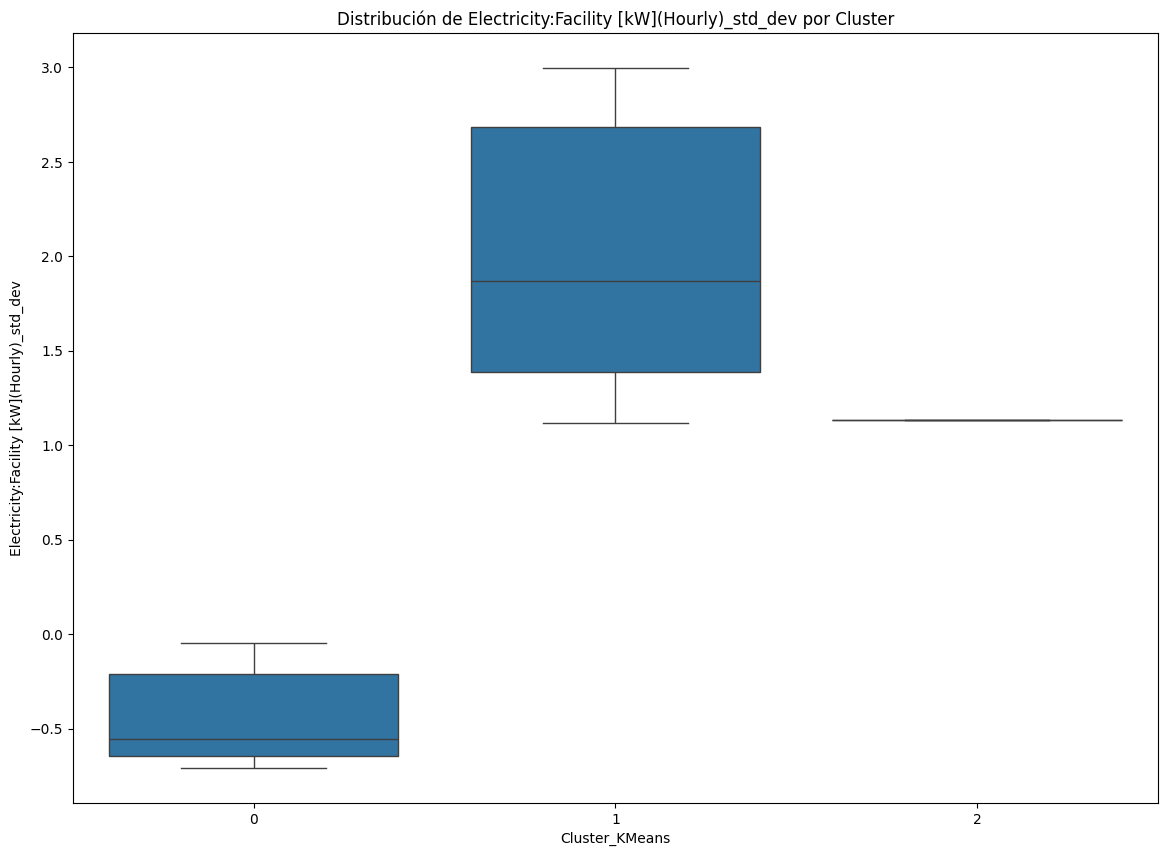

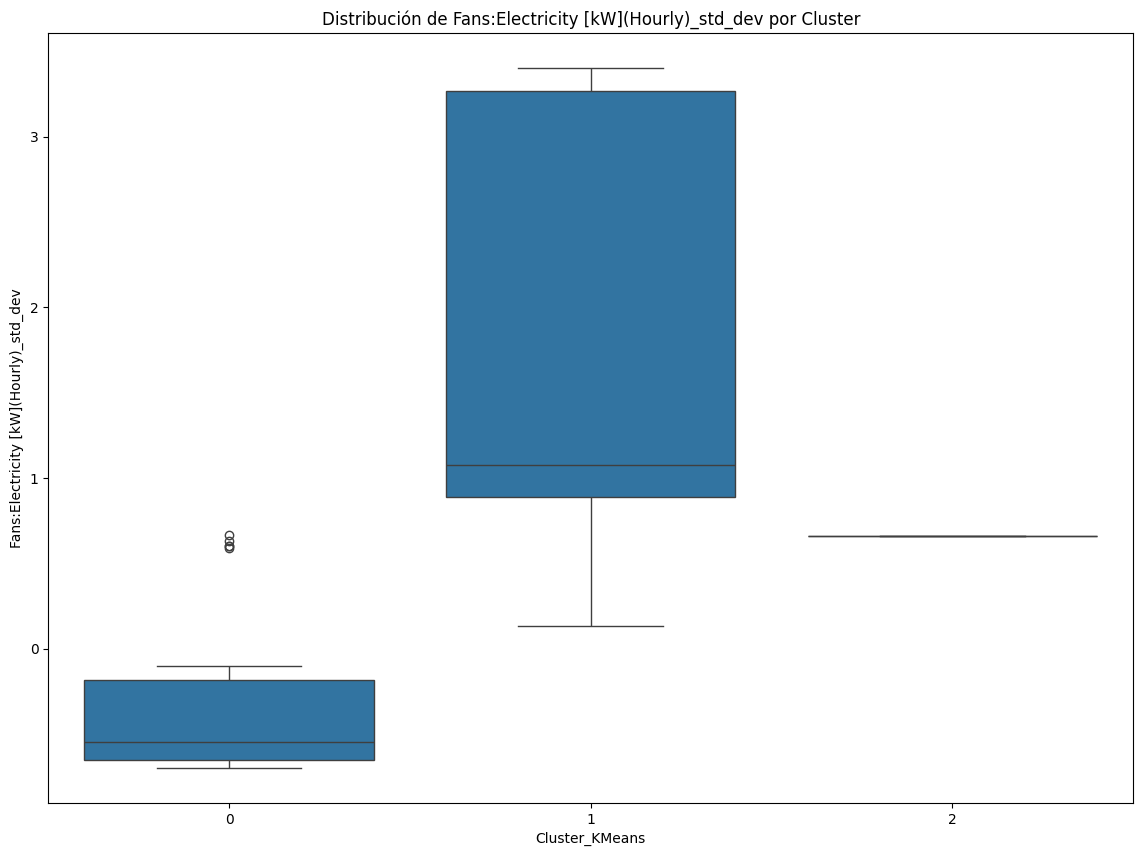

In [124]:
# Analizar algunas de las variables originales más influyentes en los componentes principales
influential_vars = pca_loadings.abs().sum(axis=1).sort_values(ascending=False).head(5).index

for var in influential_vars:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x=principal_df['Cluster_KMeans'], y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

## DBSCAN

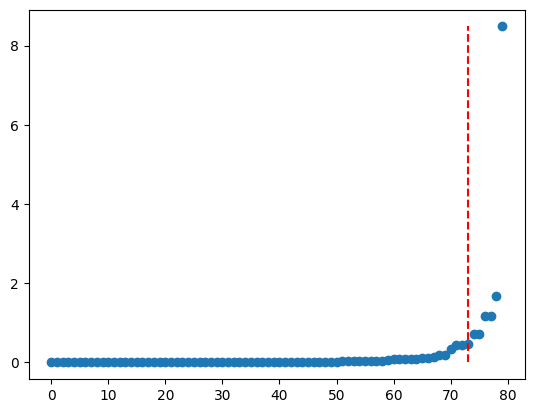

0.4779379058727117


In [126]:
#Calling our main function
idx, eps = get_eps(principal_df.iloc[:, :4])

#Showing the rotated version used for find the elbow.
plt.show()

#Printing the exact values of our eps, from here we will round it
#and use it for our DBSCAN method.
print(eps)

In [127]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(principal_df.iloc[:, :4])

# Agregar los clusters al DataFrame para análisis posterior
principal_df['Cluster_DBSCAN'] = clusters_dbscan

# Mostrar los primeros registros con los clusters asignados por DBSCAN
principal_df.head()

(        PC1       PC2       PC3       PC4  Cluster_KMeans  Cluster_DBSCAN
 0 -0.968858 -0.596223  0.144064 -0.181316               0               0
 1 -0.966817 -0.595789  0.143797 -0.180974               0               0
 2 -0.963688 -0.595137  0.143282 -0.180477               0               0
 3 -0.976218 -0.597672  0.145726 -0.182308               0               0
 4 -0.975393 -0.597554  0.145373 -0.182300               0               0,
 0.4563143983642387)

**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [132]:
# Calcular el silhouette score para evaluar la calidad de los clusters, excluyendo los puntos ruidosos
if len(set(clusters_dbscan)) > 1:
    silhouette_dbscan = silhouette_score(principal_df.iloc[:, :4], clusters_dbscan)
else:
    silhouette_dbscan = -1  # Silhouette score no es aplicable si hay un solo cluster
silhouette_dbscan

0.4563143983642387

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [135]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_dbscan= davies_bouldin_score(principal_df.iloc[:, :4], clusters_dbscan)
davies_bouldin_dbscan

1.168321470409105

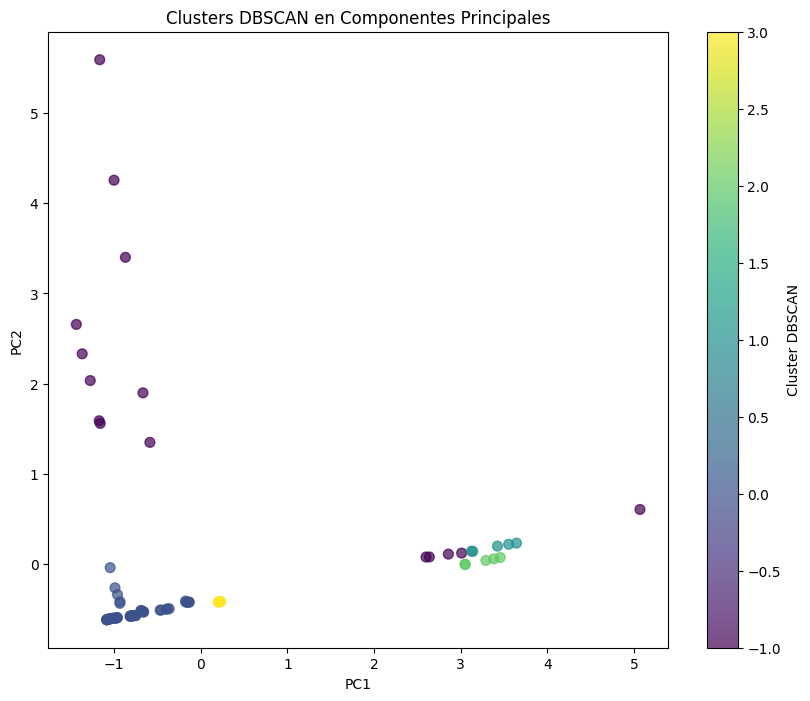

In [128]:
# Visualización de los clusters obtenidos por DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(principal_df['PC1'], principal_df['PC2'], c=principal_df['Cluster_DBSCAN'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster DBSCAN')
plt.show()

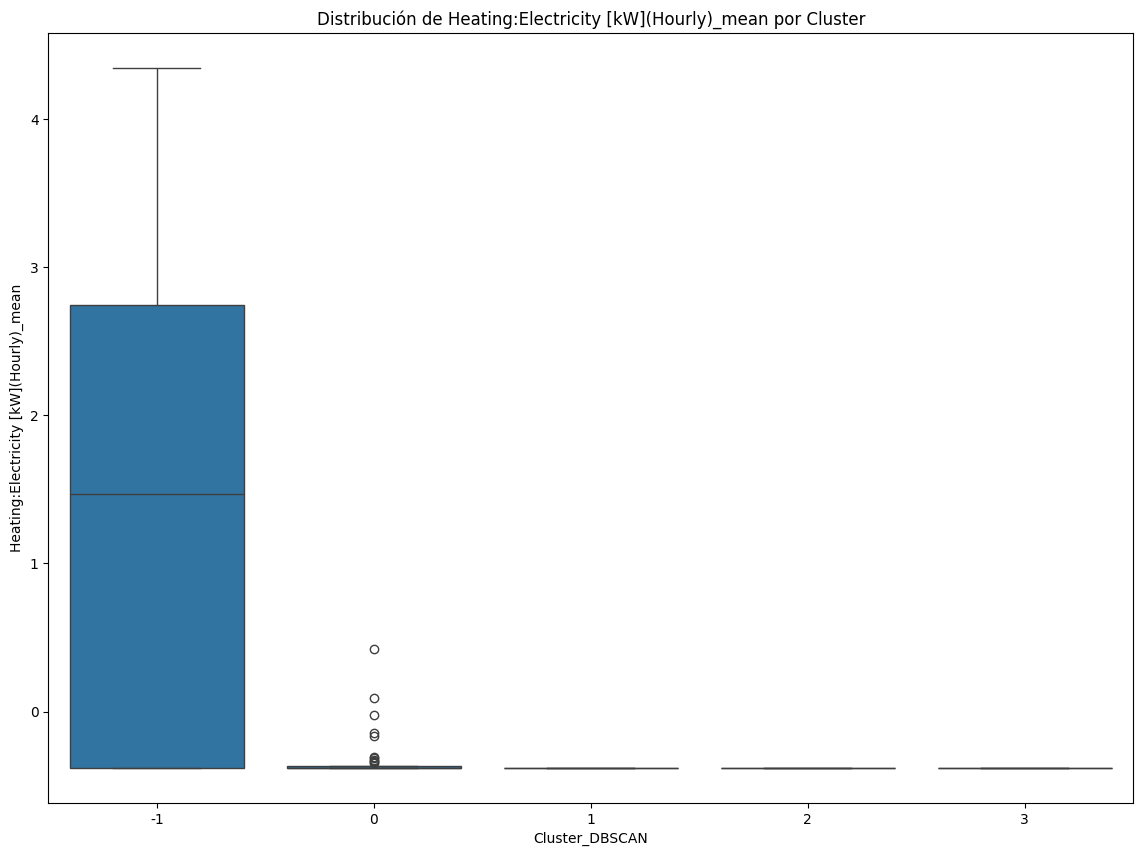

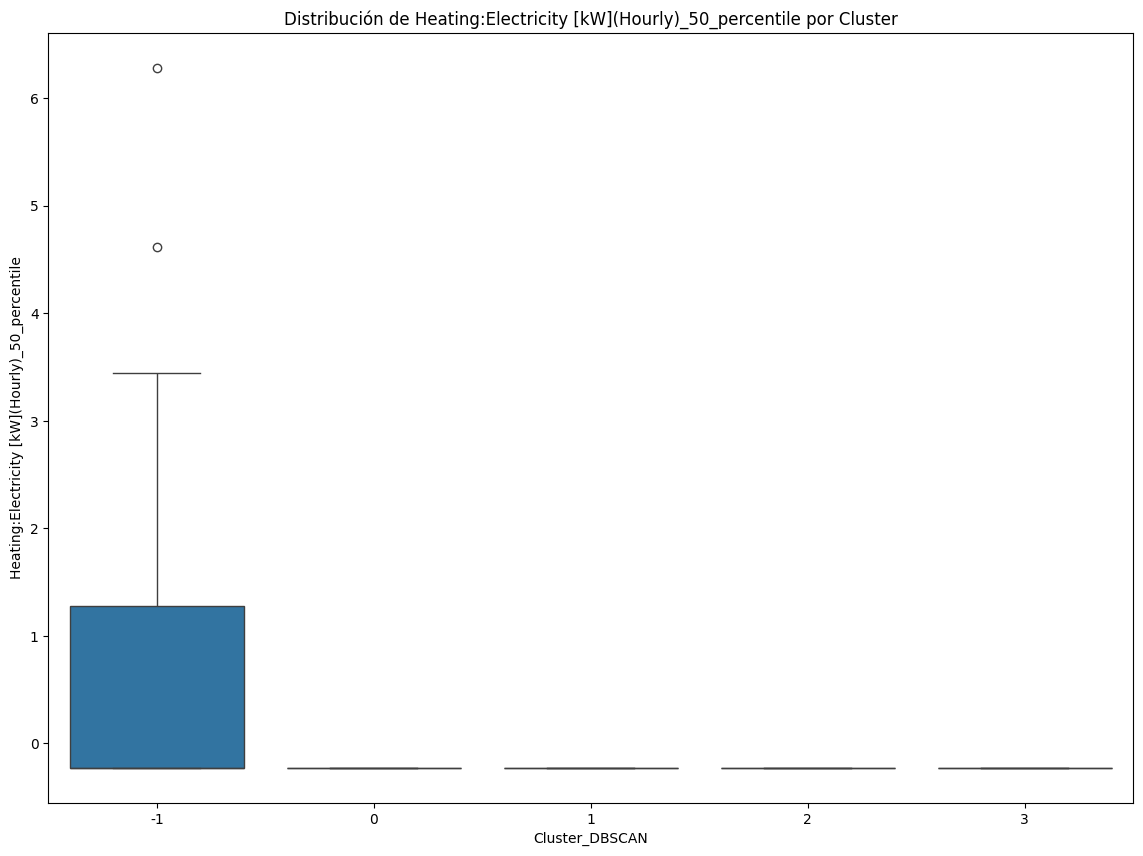

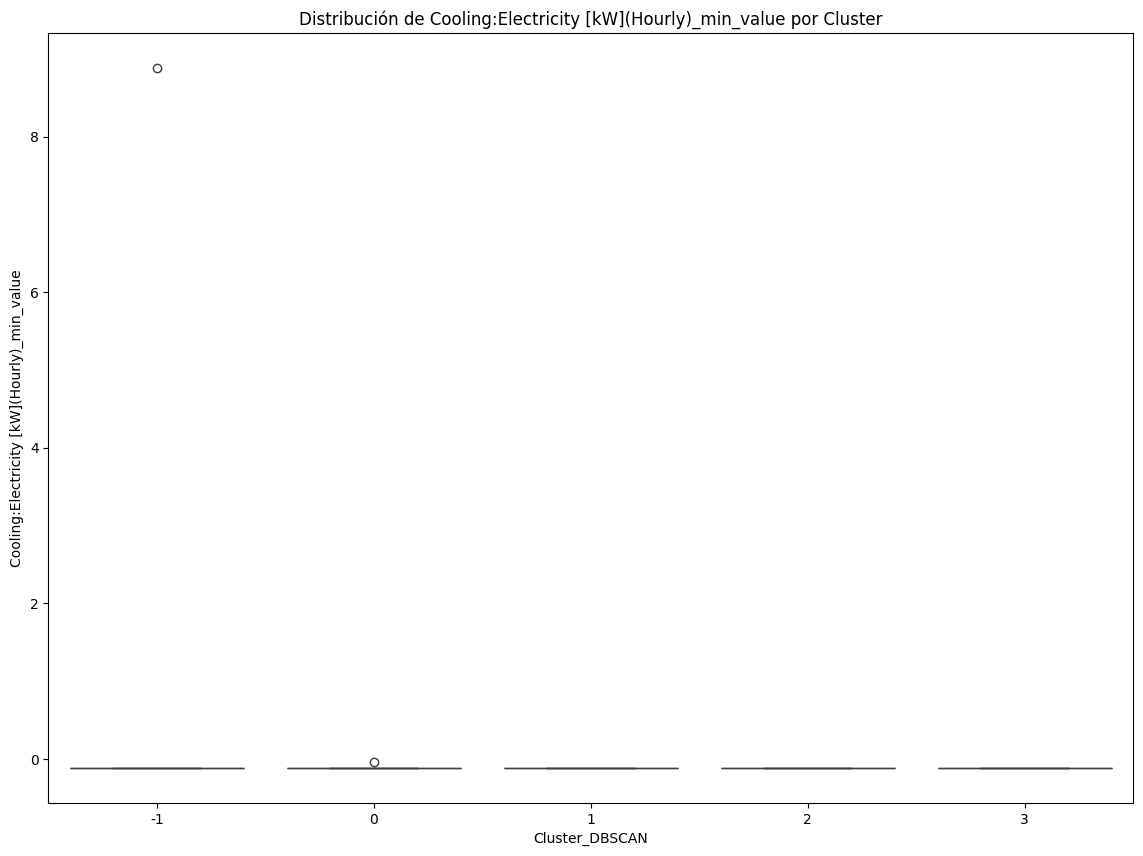

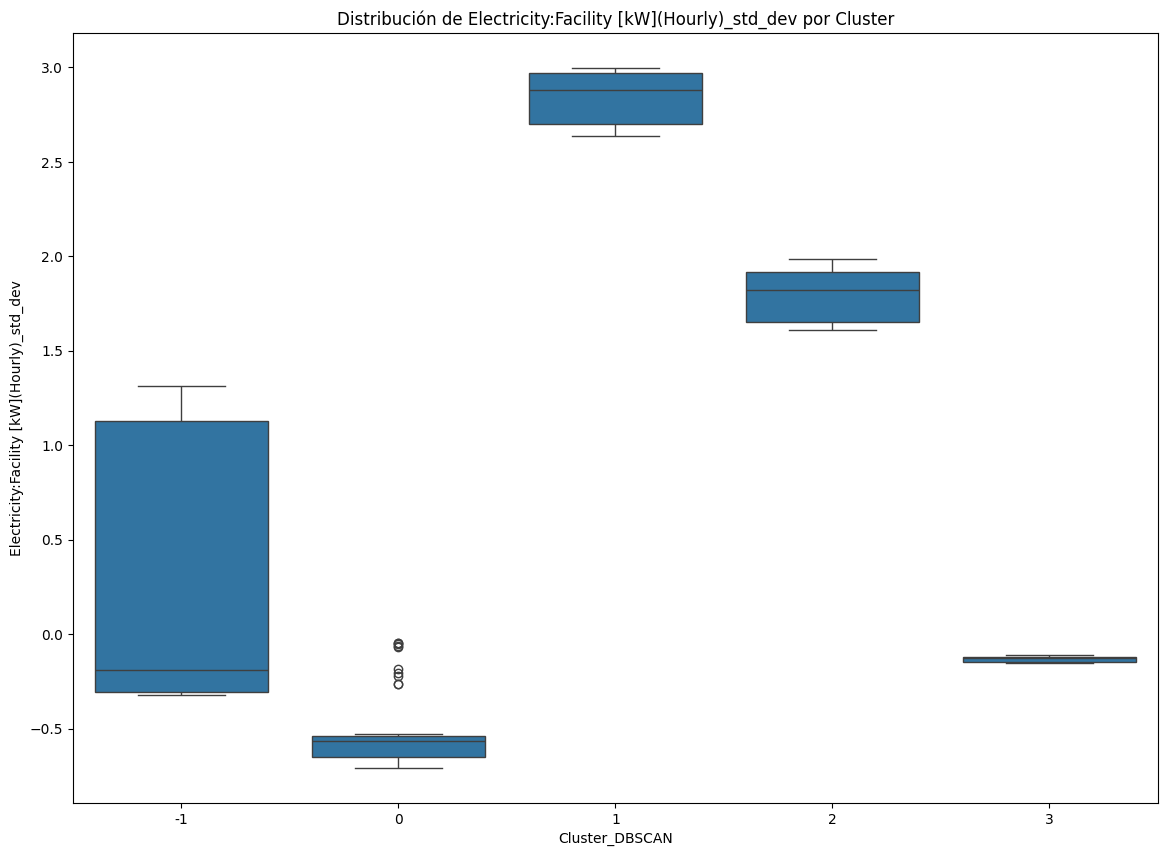

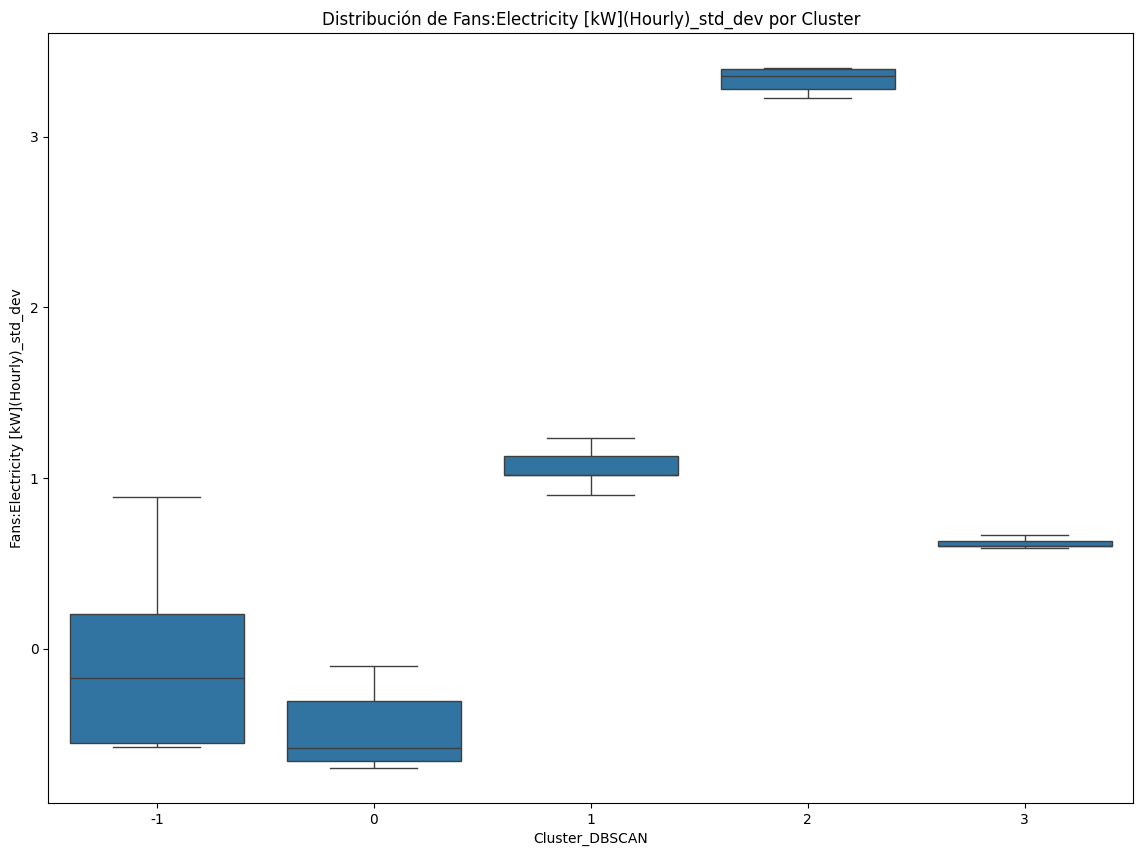

In [159]:
# Analizar algunas de las variables originales más influyentes en los componentes principales
influential_vars = pca_loadings.abs().sum(axis=1).sort_values(ascending=False).head(5).index

for var in influential_vars:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x=principal_df['Cluster_DBSCAN'], y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

## CLUSTERING HERARQUICO 

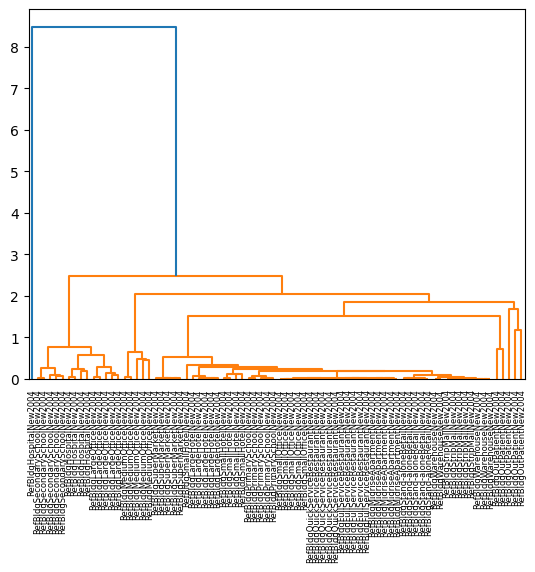

In [139]:
# Calculate the linkage: mergings
mergings = linkage(principal_df.iloc[:, :4],method='single')

# Plot the dendrogram
dendrogram(mergings,labels= data_reduced['type_building'].tolist(),leaf_rotation=90,leaf_font_size=6)
plt.show()

In [140]:
# Calcular el linkage matrix
mergings = linkage(principal_df.iloc[:, :4], method='single')

# Calcular las alturas de los clusters
last = mergings[-10:, 2]
last_rev = last[::-1]
indexes = np.arange(1, len(last) + 1)

# Calcular la aceleración
acceleration = np.diff(last, 2)  # Segunda derivada de las alturas
acceleration_rev = acceleration[::-1]

# Encontrar el número óptimo de clusters
k = acceleration_rev.argmax() + 2  # +2 porque la primera derivada se pierde y Python indexa desde 0

print(f'El número óptimo de clusters es: {k}')

El número óptimo de clusters es: 2


In [150]:
# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=2)
clusters_hierarchical = hierarchical.fit_predict(principal_df.iloc[:, :4])

# Agregar los clusters al DataFrame para análisis posterior
principal_df['Cluster_Hierarchical'] = clusters_hierarchical

# Mostrar los primeros registros con los clusters asignados por Clustering Jerárquico
principal_df.head()

,PC1,PC2,PC3,PC4,Cluster_KMeans,Cluster_DBSCAN,Cluster_Hierarchical
0,-0.968858,-0.596223,0.144064,-0.181316,0,0,0
1,-0.966817,-0.595789,0.143797,-0.180974,0,0,0
2,-0.963688,-0.595137,0.143282,-0.180477,0,0,0
3,-0.976218,-0.597672,0.145726,-0.182308,0,0,0
4,-0.975393,-0.597554,0.145373,-0.182300,0,0,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [151]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_hierarchical = silhouette_score(principal_df.iloc[:, :4], clusters_hierarchical)
silhouette_hierarchical

0.6837201697838806

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [152]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_hierarchical= davies_bouldin_score(principal_df.iloc[:, :4], clusters_hierarchical)
davies_bouldin_hierarchical

0.6020345318930824

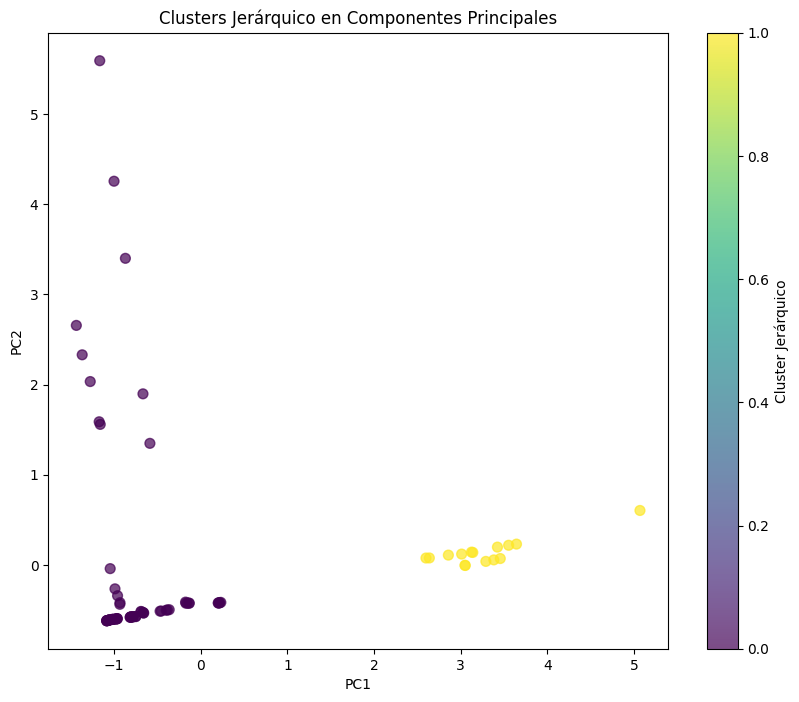

In [153]:
# Visualización de los clusters obtenidos por Clustering Jerárquico
plt.figure(figsize=(10, 8))
plt.scatter(principal_df["PC1"], principal_df['PC2'], c=principal_df['Cluster_Hierarchical'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters Jerárquico en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Jerárquico')
plt.show()

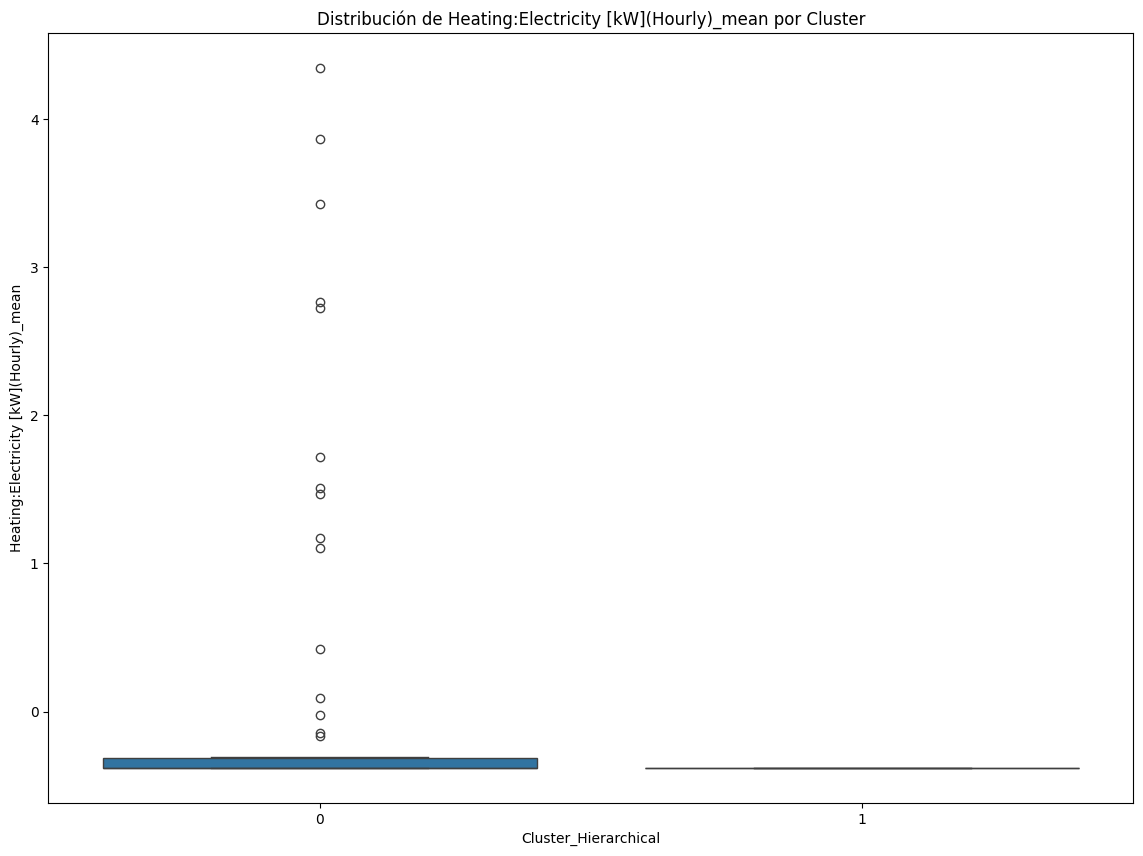

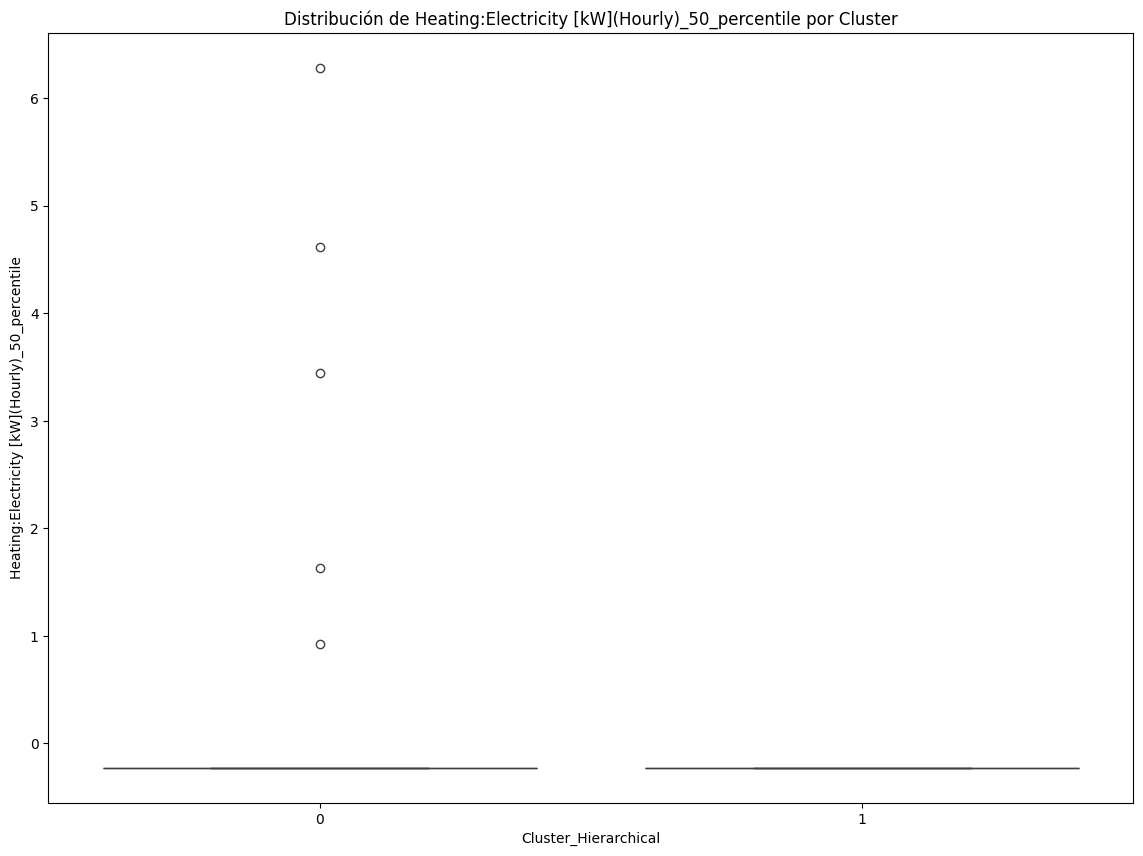

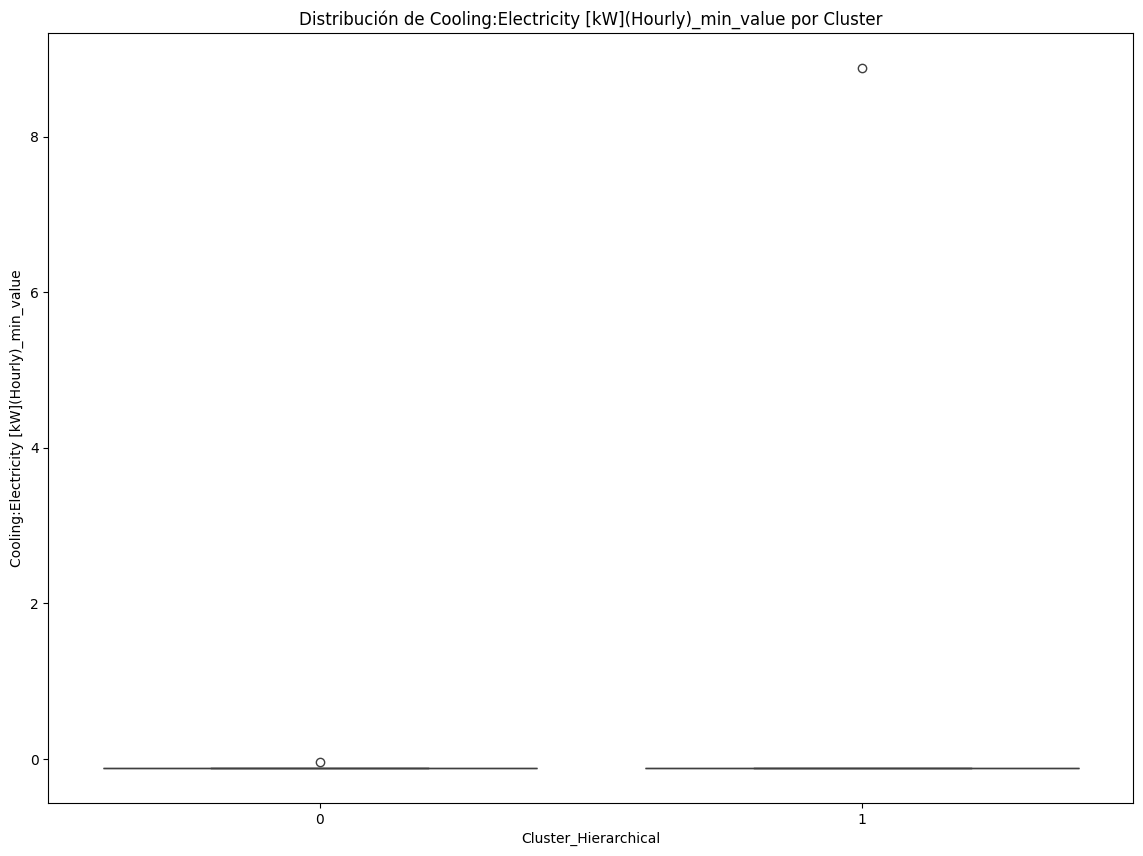

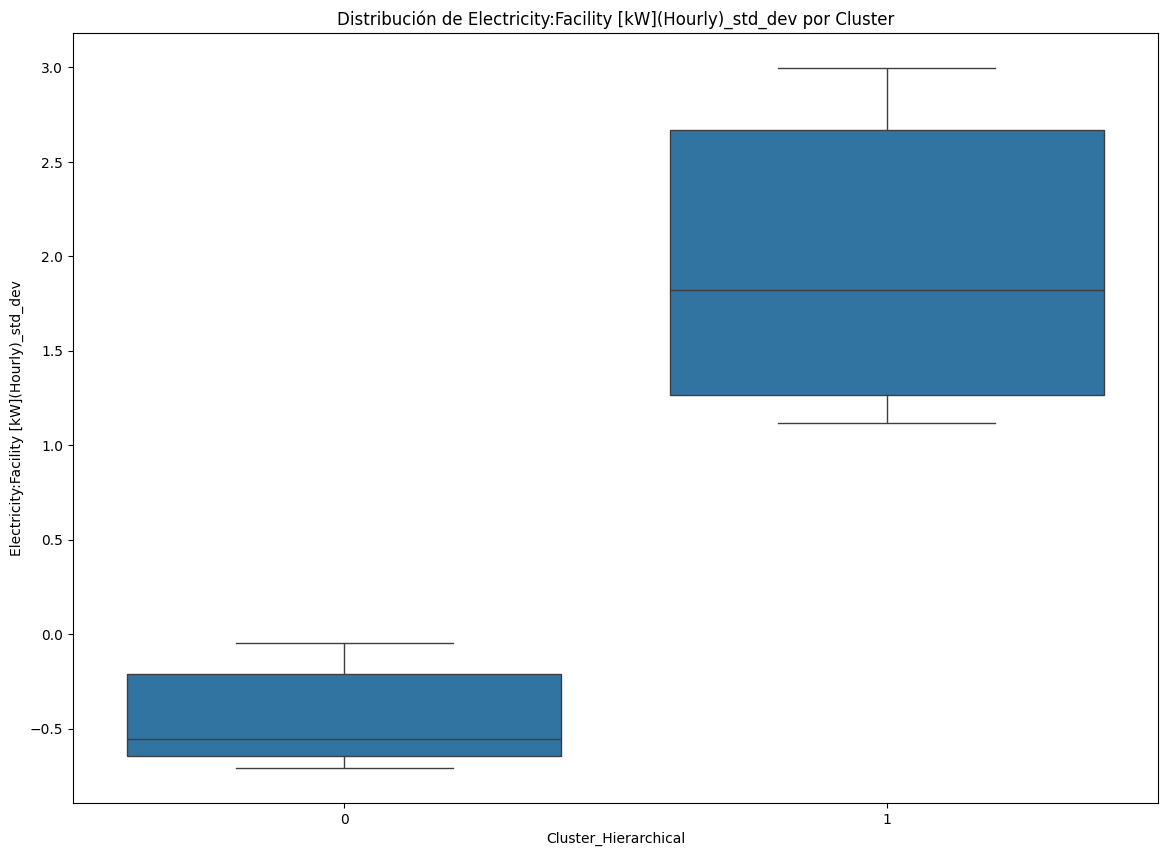

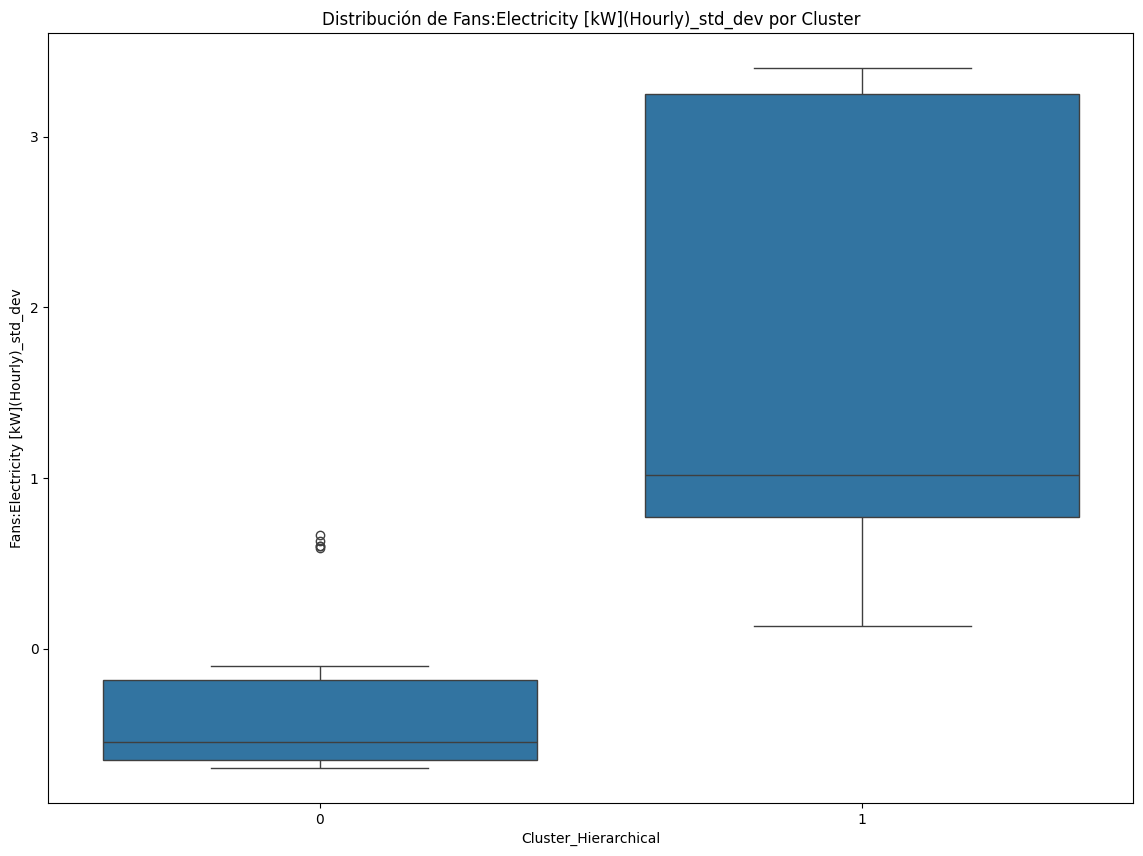

In [160]:
# Analizar algunas de las variables originales más influyentes en los componentes principales
influential_vars = pca_loadings.abs().sum(axis=1).sort_values(ascending=False).head(5).index

for var in influential_vars:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x=principal_df['Cluster_Hierarchical'], y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()